In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [181]:
import warnings
warnings.filterwarnings("ignore")

In [182]:
df = pd.read_csv('./MarketData.csv')
print('Shape of data set ',df.shape)
df.head()

Shape of data set  (5232, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


We notice in the visible values that, 'Adj Close' and 'Close' values look same. Checking on the whole dataset.

In [183]:
df[df.Close != df['Adj Close']].shape

(0, 7)

Both the columns contain same values. Hence, we can drop one of the columns without affecting the data.

In [184]:
# Dropping 'Adj Close' column
df.drop(['Adj Close'], axis = 1, inplace = True) 

In [185]:
# Checking for NA values
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [186]:
# Checking datatype of columns
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [187]:
# Converting Date column to datetime for ease of accessibility of this column
df.Date = pd.to_datetime(df.Date)
df.head()

,Date,Open,High,Low,Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000


# Section 1

Examine the daily volume data and identify the optimal number of clusters for daily volume data

In [230]:
(df.Volume.iloc[-1] - df.Volume.iloc[0])/df.Volume.iloc[-1]

0.8007224293129223

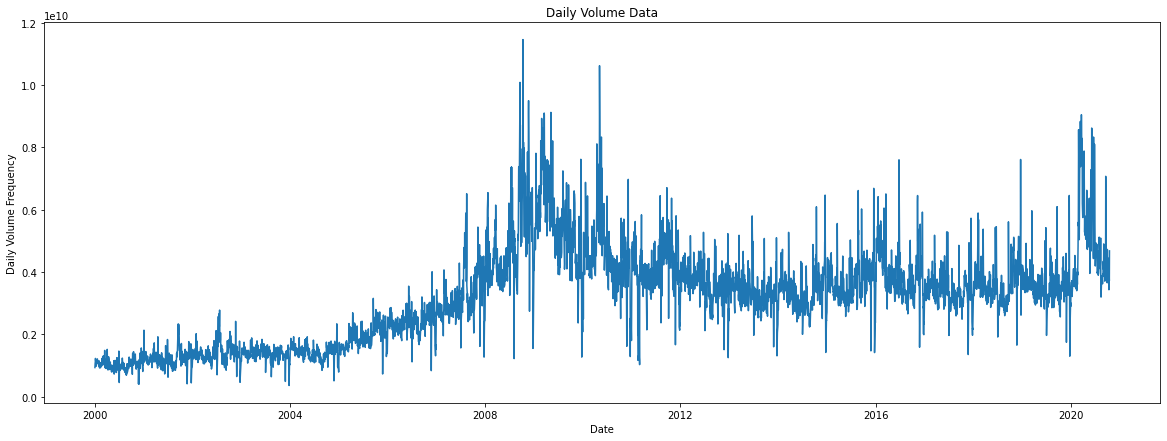

In [226]:
figure = plt.figure(figsize = (20,7))
plt.plot(df.Date, df.Volume)
plt.xlabel('Date')
plt.ylabel('Daily Volume Frequency')
plt.title('Daily Volume Data')
plt.show()

### Elbow method

Within-Cluster-Sum-of-Squares (WCSS) is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1.

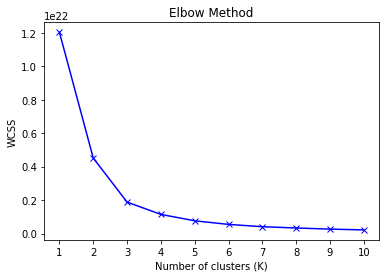

In [188]:
from sklearn.cluster import KMeans

wcss = []
x = np.linspace(1, 10, 10).astype('int')
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df.Volume.values.reshape(-1,1))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(x)
plt.show()

We can see that the curve changes rapidly when K = 3 creating an elbow shape. Hence, the <b>optimal number of clusters for daily volume data are 3.</b>

# Section 2

Compute fractional differences and clustering those data points

In [189]:
# Function to calculate fractional difference of current day and previous day features

def curr_vs_prev(dataframe, column):
    values = [0]
    for i in range(len(dataframe)):
        if i < len(dataframe) - 1:
            val = (dataframe.iloc[i+1][column]/dataframe.iloc[i][column]) - 1
            values.append(val)
        else:
            break
    return values

In [190]:
# Creating fractional difference data set to calculate the parameters required

fractional_diff_data = pd.DataFrame()

# Parameter 1 : fractional difference between current day open and previous day open
fractional_diff_data['Open frac_diff'] = curr_vs_prev(df, 'Open') 

# Parameter 2 : fractional difference between current day open and current day close 
fractional_diff_data['Curr_open_close frac_diff'] = (df.Open/df.Close) - 1 

# Parameter 3 : fractional difference between current day volume and previous day volume
fractional_diff_data['Volume frac_diff'] = curr_vs_prev(df, 'Volume') 

fractional_diff_data['Volume frac_diff'] = fractional_diff_data['Volume frac_diff'].astype(float)
fractional_diff_data['Open frac_diff']   = fractional_diff_data['Open frac_diff'].astype(float)

print(fractional_diff_data.shape)
fractional_diff_data.head()

(5232, 3)


,Open frac_diff,Curr_open_close frac_diff,Volume frac_diff
0,0.000000,0.009641,0.000000
1,-0.009549,0.039874,0.082850
2,-0.038345,-0.001918,0.075818
3,0.001922,-0.000955,0.006264
4,0.000956,-0.026376,0.121670


To cluster the above dataset, first we need to find the number of clusters/components. I will be using Gaussian Mixture Model(GMM) for finding the optimal number of clusters and to fit the data. <br>
I will be using Bayesian Information Criterion (BIC) to test how good our GMM is at predicting the data we have.

In [191]:
from sklearn import mixture
import itertools

lowest_bic = np.infty
bic = []

n_components_range = range(1, 10)
cv_types = ["spherical", "tied", "diag", "full"]

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components = n_components, covariance_type = cv_type)
        gmm.fit(fractional_diff_data.to_numpy())
        bic.append(gmm.bic(fractional_diff_data.to_numpy()))
        
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            print(cv_type, bic[-1])
            

bic = np.array(bic)
X = best_gmm

print('\nNumber of optimal components : ', X.n_components)
print('Covariance type : ', X.covariance_type)
print('BIC Score : ', X.bic(fractional_diff_data.to_numpy()))
print('AIC Score : ', X.aic(fractional_diff_data.to_numpy()))

spherical -21782.29698202833
spherical -34187.46536107308
spherical -42361.78550311802
spherical -48411.42454535898
spherical -52626.69612315882
spherical -55256.56204019132
spherical -57804.19153520622
spherical -59087.622609132486
spherical -59638.297901003054
tied -65007.815904318835
tied -66633.80125644864
tied -67006.96841786768
tied -67736.59130591454
tied -67879.23609028713
diag -69841.2958061987
diag -70479.58931151507
diag -70500.77326771036
diag -70850.89590886312
diag -70872.33703777706
diag -70959.18665882965

Number of optimal components :  7
Covariance type :  diag
BIC Score :  -70959.18665882965
AIC Score :  -71274.18900570023


### PCA for dimensionality reduction

In [192]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) 
X_principal = PCA(n_components = 2).fit_transform(fractional_diff_data.to_numpy()) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

X_principal.head()

,P1,P2
0,-0.018276,0.005263
1,0.064671,0.014408
2,0.057576,-0.032933
3,-0.012044,0.000877
4,0.103295,-0.014261


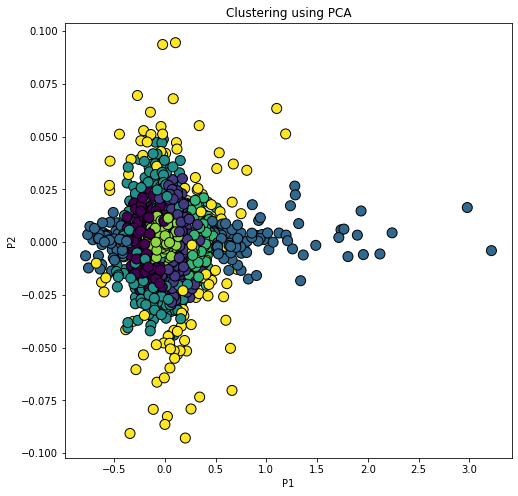

In [193]:
figure = plt.figure(figsize = (8,8))

plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = X.fit_predict(fractional_diff_data),
           edgecolors = 'k',
           s = 100)

plt.title('Clustering using PCA')
plt.xlabel('P1')
plt.ylabel('P2')
plt.show() 

### TSNE for dimensionality reduction

In [194]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components = 2, init = 'random').fit_transform(fractional_diff_data.to_numpy())
X_embedded = pd.DataFrame(X_embedded) 
X_embedded.columns = ['P1', 'P2'] 

X_embedded.head()

,P1,P2
0,36.107403,8.129901
1,-15.844887,43.591949
2,-1.843519,40.451591
3,42.557072,13.495919
4,-48.914734,49.223221


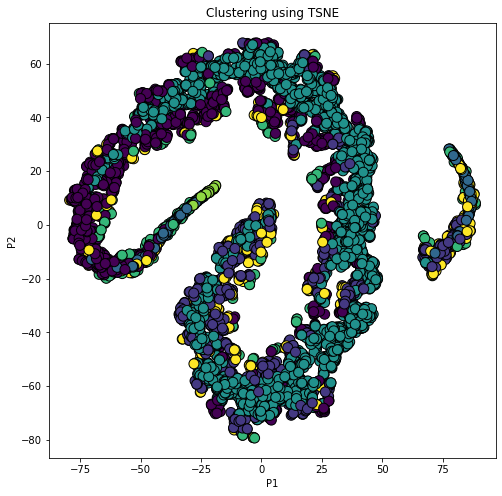

In [195]:
figure = plt.figure(figsize = (8,8))

plt.scatter(X_embedded['P1'], X_embedded['P2'], 
           c = X.fit_predict(fractional_diff_data),
           edgecolors = 'k',
           s = 100) 

plt.title('Clustering using TSNE')
plt.xlabel('P1')
plt.ylabel('P2')
plt.show() 

# Section 3

Computing the monthly returns and using decision tree to classify if investing in any month can be a profitable strategy.

In [196]:
# Finding month and year of each data point

df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year
df

,Date,Open,High,Low,Close,Volume,Month,Year
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,1,2000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,1,2000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,1,2000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,1,2000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,1,2000
...,...,...,...,...,...,...,...,...
5227,2020-10-12,3500.020020,3549.850098,3499.610107,3534.219971,3428970000,10,2020
5228,2020-10-13,3534.010010,3534.010010,3500.860107,3511.929932,3605150000,10,2020
5229,2020-10-14,3515.469971,3527.939941,3480.550049,3488.669922,3840630000,10,2020
5230,2020-10-15,3453.719971,3489.080078,3440.889893,3483.340088,3717640000,10,2020


In [197]:
df.groupby(['Year','Month']).aggregate(['first','last'])

Date                    Open                      High  \
                first       last        first         last        first   
Year Month                                                                
2000 1     2000-01-03 2000-01-31  1469.250000  1360.160034  1478.000000   
     2     2000-02-01 2000-02-29  1394.459961  1348.050049  1412.489990   
     3     2000-03-01 2000-03-31  1366.420044  1487.920044  1383.459961   
     4     2000-04-03 2000-04-28  1498.579956  1464.920044  1507.189941   
     5     2000-05-01 2000-05-31  1452.430054  1422.439941  1481.510010   
...               ...        ...          ...          ...          ...   
2020 6     2020-06-01 2020-06-30  3038.780029  3050.199951  3062.179932   
     7     2020-07-01 2020-07-31  3105.919922  3270.449951  3128.439941   
     8     2020-08-03 2020-08-31  3288.260010  3509.729980  3302.729980   
     9     2020-09-01 2020-09-30  3507.439941  3341.209961  3528.030029   
     10    2020-10-01 2020-10-16  3385.870117  3493.500000  3397.179932   

                                 Low                     Close               \
                   last        first         last        first         last   
Year Month                                                                    
2000 1      1394.479980  1438.359985  1350.140015  1455.219971  1394.459961   
     2      1369.630005  1384.790039  1348.050049  1409.280029  1366.420044   
     3      1519.810059  1366.420044  1484.380005  1379.189941  1498.579956   
     4      1473.619995  1486.959961  1448.150024  1505.969971  1452.430054   
     5      1434.489990  1452.430054  1415.500000  1468.250000  1420.599976   
...                 ...          ...          ...          ...          ...   
2020 6      3111.510010  3031.540039  3047.830078  3055.729980  3100.290039   
     7      3272.169922  3101.169922  3220.260010  3115.860107  3271.120117   
     8      3514.770020  3284.530029  3493.250000  3294.610107  3500.310059   
     9      3393.560059  3494.600098  3340.469971  3526.649902  3363.000000   
     10     3515.760010  3361.389893  3480.449951  3380.800049  3483.810059   

                Volume              
                 first        last  
Year Month                          
2000 1       931800000   993800000  
     2       981000000  1204300000  
     3      1274100000  1227400000  
     4      1021700000   984600000  
     5       966300000   960500000  
...                ...         ...  
2020 6      4673410000  4696280000  
     7      4443130000  5117260000  
     8      4643640000  4342290000  
     9      4083110000  4722530000  
     10     4070530000  4675890000  

[250 rows x 12 columns]

To reach our final Monthly Returns dataset, we need to do pre-processing using the above dataset. <br>
In the cell below, different functions have been used to achieve a specific task. 

In [210]:
# Monthly returns = [Closing price (last day) / Closing price (first day)] - 1 

# The below function will be used to calculate monthly returns when colname = 'Close'
def prev_monthly_return(dataset, colname, new_colname): # Assigning previous month's returns to consecutive months
    dataset[new_colname] = 0
    for i in range(len(monthly_returns)):
        dataset[new_colname].loc[i+1] = dataset[colname].loc[i]
    return dataset


def monthly_fractional_fun(colname): # Computing Monthly fractional difference of colnames in original dataset
    first = df.groupby(['Year','Month']).aggregate(['first','last']).loc[:,colname].loc[:,'first']
    last = df.groupby(['Year','Month']).aggregate(['first','last']).loc[:,colname].loc[:,'last']
    final = (last / first) - 1
    return pd.DataFrame(final)


def convert_to_std_dataframe(dataset, colname): # Convert different datasets to a standard format
    dataset.columns = [colname]
    dataset['Year']  = dataset.index.get_level_values('Year') # extracting year from the index
    dataset['Month'] = dataset.index.get_level_values('Month') # extracting month from the index
    dataset.index = range(len(dataset)) # setting the index to standard
    return dataset


def final_return_fun(dataset, colname): # Use High, Vol, Low datasets to obtain final monthly_returns dataset
    monthly_returns[colname] = dataset[colname]
    return monthly_returns

In [211]:
# Calculating Monthly returns and fractional difference of colnames from monthly data
monthly_returns = monthly_fractional_fun('Close')
vol, low, high = monthly_fractional_fun('Volume'), monthly_fractional_fun('Low'), monthly_fractional_fun('High') 

# Converting all columns to standard format
monthly_returns = convert_to_std_dataframe(monthly_returns, 'Monthly_returns')
vol, low, high = convert_to_std_dataframe(vol, 'Vol'),convert_to_std_dataframe(low, 'Low'),convert_to_std_dataframe(high, 'High')

# Returning previous month values
monthly_returns = prev_monthly_return(monthly_returns, 'Monthly_returns', 'Monthly_returns_prev')
vol, low, high = prev_monthly_return(vol, 'Vol', 'Vol_prev'), prev_monthly_return(low, 'Low', 'Low_prev'), prev_monthly_return(high, 'High', 'High_prev')


In [212]:
monthly_returns = final_return_fun(vol, 'Vol_prev')
monthly_returns = final_return_fun(high, 'High_prev')
monthly_returns = final_return_fun(low, 'Low_prev')
monthly_returns

,Monthly_returns,Year,Month,Monthly_returns_prev,Vol_prev,High_prev,Low_prev
0,-0.041753,2000,1,0.000000,0.000000,0.000000,0.000000
1,-0.030413,2000,2,-0.041753,0.066538,-0.056509,-0.061334
2,0.086565,2000,3,-0.030413,0.227625,-0.030344,-0.026531
3,-0.035552,2000,4,0.086565,-0.036653,0.098557,0.086328
4,-0.032454,2000,5,-0.035552,-0.036312,-0.022273,-0.026100
...,...,...,...,...,...,...,...
245,0.014582,2020,6,0.075458,0.530578,0.062765,0.062730
246,0.049829,2020,7,0.014582,0.004894,0.016109,0.005374
247,0.062435,2020,8,0.049829,0.151724,0.045943,0.038402
248,-0.046404,2020,9,0.062435,-0.064895,0.064201,0.063546


In [213]:
# Removing first row as Monthly_prev = 0, which can affect our decision tree model while training
monthly_returns = monthly_returns.iloc[1:]
monthly_returns.shape

(249, 7)

In [214]:
# Creating Target labels :
# positive returns as 1 
# negative returns as 0

monthly_returns['Target'] = (monthly_returns['Monthly_returns'] > 0).astype(int)

print('Our final dataset looks like this!! Finally!')
print('Shape of final dataset : ', monthly_returns.shape)

monthly_returns.head()

Our final dataset looks like this!! Finally!
Shape of final dataset :  (249, 8)


,Monthly_returns,Year,Month,Monthly_returns_prev,Vol_prev,High_prev,Low_prev,Target
1,-0.030413,2000,2,-0.041753,0.066538,-0.056509,-0.061334,0
2,0.086565,2000,3,-0.030413,0.227625,-0.030344,-0.026531,1
3,-0.035552,2000,4,0.086565,-0.036653,0.098557,0.086328,0
4,-0.032454,2000,5,-0.035552,-0.036312,-0.022273,-0.026100,0
5,0.003996,2000,6,-0.032454,-0.006002,-0.031738,-0.025426,1


### Implementing Decision Tree for classification

#### Decision Tree Classfier

In [242]:
# Splitting the data set into train and test data

from sklearn.model_selection import train_test_split

features = ['Monthly_returns_prev','Vol_prev','Low_prev','High_prev']

X_train,X_test, y_train, y_test = train_test_split(monthly_returns[features].to_numpy(),
                                                   monthly_returns[['Target']].to_numpy(), train_size = 0.7)

In [216]:
from sklearn import tree

X, y = X_train, y_train
dec_tree = tree.DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train)

In [217]:
text_representation = tree.export_text(dec_tree)
print(text_representation)

|--- feature_0 <= -0.08
|   |--- feature_0 <= -0.13
|   |   |--- feature_2 <= -0.15
|   |   |   |--- class: 0
|   |   |--- feature_2 >  -0.15
|   |   |   |--- class: 1
|   |--- feature_0 >  -0.13
|   |   |--- class: 0
|--- feature_0 >  -0.08
|   |--- feature_1 <= -0.56
|   |   |--- class: 1
|   |--- feature_1 >  -0.56
|   |   |--- feature_0 <= -0.06
|   |   |   |--- feature_1 <= 0.53
|   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  0.53
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  -0.06
|   |   |   |--- feature_2 <= -0.04
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  -0.04
|   |   |   |   |--- class: 1



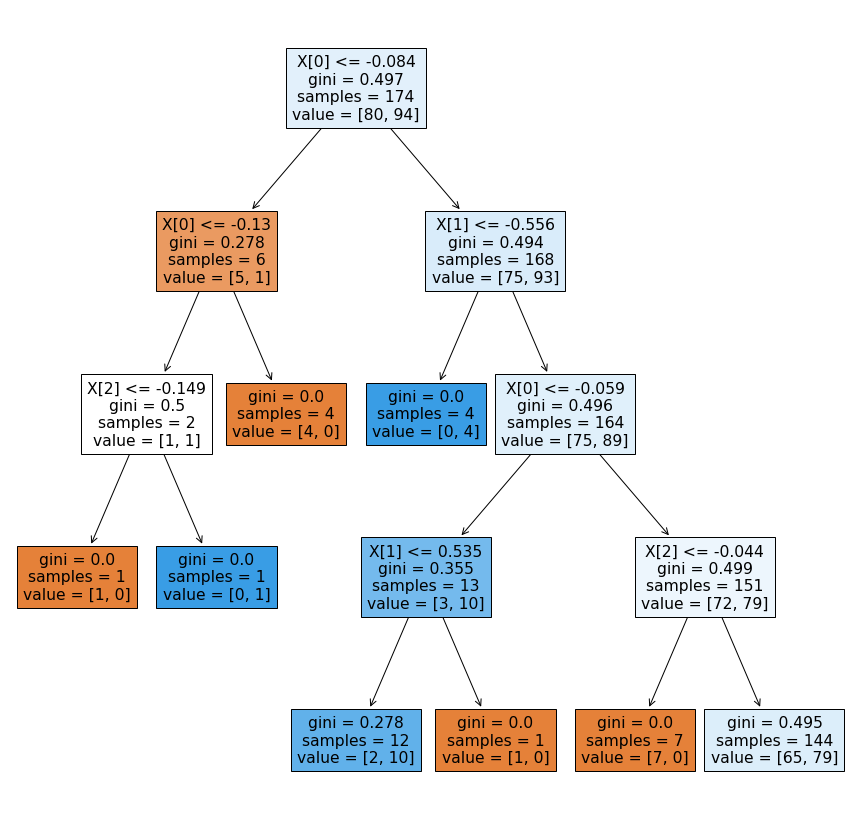

In [218]:
figure = plt.figure(figsize = (15,15))
_ = tree.plot_tree(dec_tree, filled = True)

In [219]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

res_pred = dec_tree.predict(X_test)
score = accuracy_score(y_test, res_pred)
print('Accuracy : ',score*100, '%')
print('ROC AUC score is : ',roc_auc_score(y_test, dec_tree.predict_proba(X_test)[:,1]))

Accuracy :  66.66666666666666 %
ROC AUC score is :  0.5276


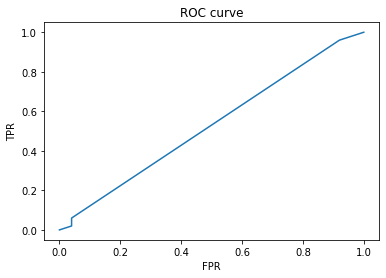

In [220]:
# Plotting AUROC curve
fpr, tpr, _ = roc_curve(y_test, dec_tree.predict_proba(X_test)[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR') # False Positive Rate
plt.ylabel('TPR') # True Positive Rate
plt.title('ROC curve')
plt.show()

In [221]:
dec_tree.predict([[0.5, -0.1, 0.2, -0.3]])

array([1])

In [243]:
from sklearn.model_selection import cross_val_score

dec_tree = tree.DecisionTreeClassifier(max_depth = 4)
scores = cross_val_score(dec_tree, X_train, y_train, cv = 5)
scores

array([0.48571429, 0.57142857, 0.68571429, 0.51428571, 0.55882353])

In [245]:
print("%0.2f accuracy wtih a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.56 accuracy wtih a standard deviation of 0.07
